In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
import wrangle_zillow as w
import explore as e
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

In [2]:
df = w.get_zillow_data()

In [3]:
def fips_labels(x):
    if x['fips'] == 6037:
        return 'Los Angeles County'
    elif x['fips'] == 6059:
        return 'Orange County'
    elif x['fips'] == 6111:
        return 'Ventura County'

In [4]:
# Creating a county column
df['county'] = df.apply(lambda x: fips_labels(x), axis=1)
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc,county
0,14297519,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1727539,NaN,...,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN,Orange County
1,17052889,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1387261,NaN,...,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN,Ventura County
2,14186244,NaN,NaN,261.0,NaN,NaN,NaN,NaN,11677,NaN,...,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN,Orange County
3,12177905,NaN,NaN,261.0,2.0,NaN,NaN,NaN,2288172,NaN,...,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN,Los Angeles County
4,10887214,NaN,NaN,266.0,2.0,NaN,NaN,1.0,1970746,NaN,...,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN,Los Angeles County


In [5]:
df= w.single_unit_properties(df)
df=w.handle_missing_values(df, prop_required_column = .60, prop_required_row = .60)
train, validate, test =w.impute_missing_values(df)
train, validate, test = w.impute_missing_values_1(train, validate, test)

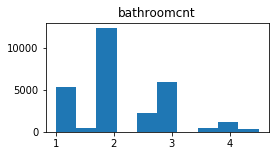

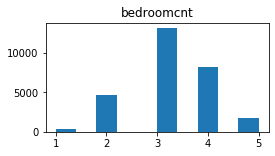

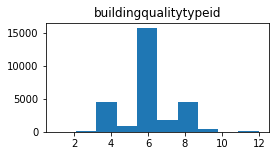

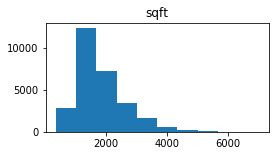

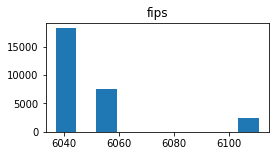

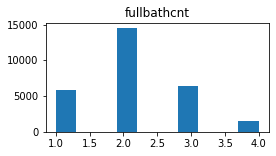

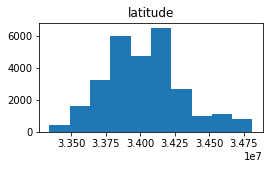

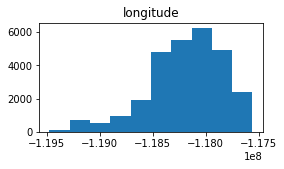

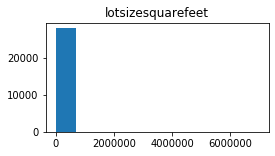

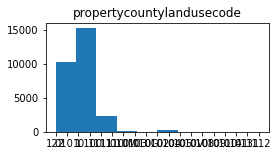

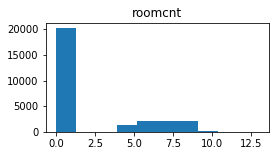

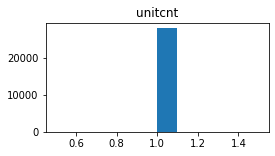

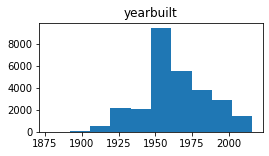

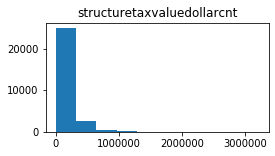

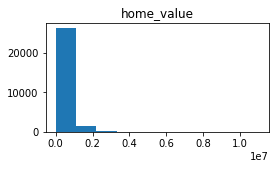

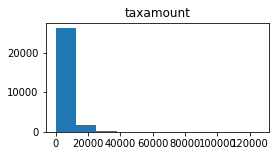

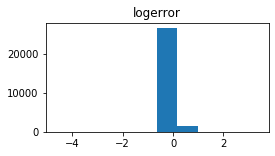

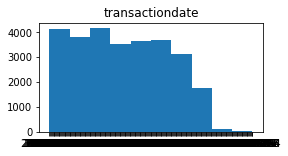

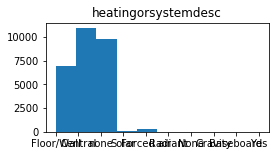

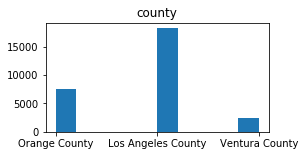

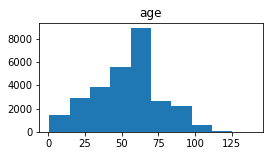

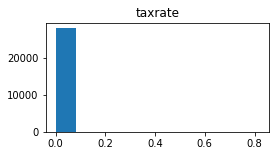

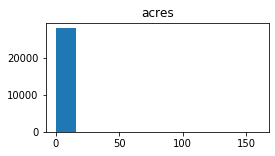

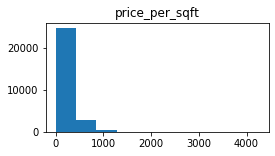

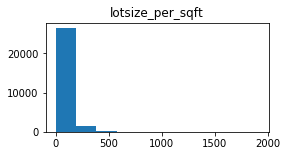

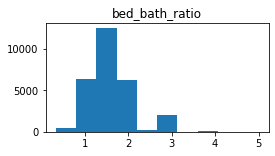

In [6]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

## Features normally distributed
    - bedroomcnt
    - building quality type id
    - fullbathcnt
    - latitude
    - year built
    - age
    - bed bath ratio
    
## Features skewed right
    - sqft
    
## Features skewed left
    - longitude
    

## Is there a relationship between price_per_sqft and logerror?

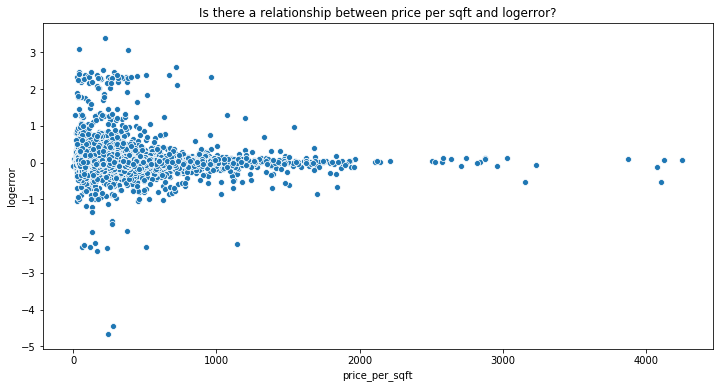

In [7]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=train, x='price_per_sqft', y='logerror')
plt.title('Is there a relationship between price per sqft and logerror?')
plt.show()

In [8]:
train['binned_price_per_sqft'] = pd.cut(train.price_per_sqft, [0,1000,2000,5000] , labels=["small", "medium", "large"])
validate['binned_price_per_sqft'] = pd.cut(validate.price_per_sqft, [0,1000,2000,5000] , labels=["small", "medium", "large"])
test['binned_price_per_sqft'] = pd.cut(test.price_per_sqft, [0,1000,2000,5000] , labels=["small", "medium", "large"])

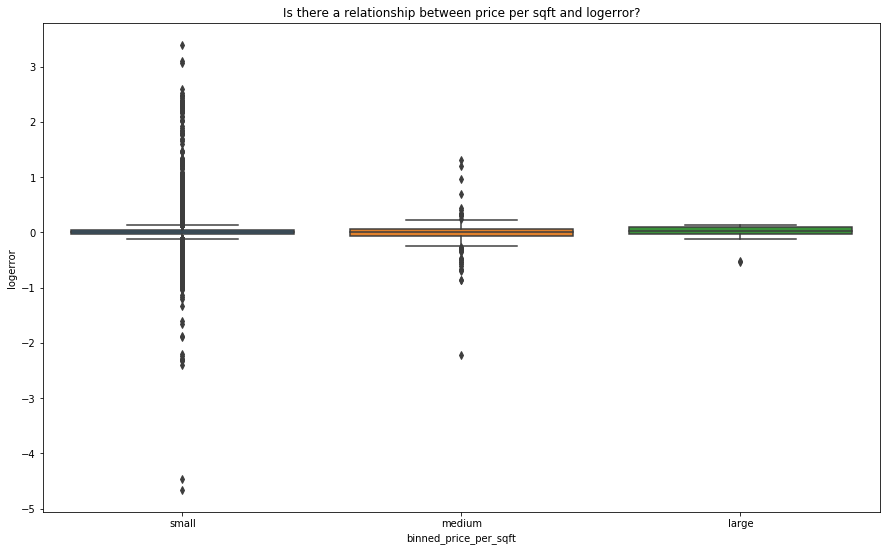

In [9]:
plt.figure(figsize=(15,9))
sns.boxplot(x= 'binned_price_per_sqft', y = 'logerror', data = train)
plt.title('Is there a relationship between price per sqft and logerror?')
plt.show()

## Hard to see if there is a correlation here. Going to run a statistical test (ANOVA) to see if there is a significance in the means of price per sqft and log error.

In [10]:
small_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'small'].price_per_sqft
medium_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'medium'].price_per_sqft
large_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'large'].price_per_sqft

- Ho: Means of binned price_per_sqft_ratio small, medium, large are equal
- Ha: Means of binned price_per_sqft_ratio, medium, large are not equal
- alpha = .05

In [11]:
print(small_price_per_sqft_ratio.var())
print(medium_price_per_sqft_ratio.var())
print(large_price_per_sqft_ratio.var())

25797.376400826815
66359.22062652641
441774.5297190322


In [12]:
f, p = stats.f_oneway(small_price_per_sqft_ratio, medium_price_per_sqft_ratio, large_price_per_sqft_ratio)
f, p

(8553.03763805571, 0.0)

- We reject the null Hypothesis. p-value is less than alpha. The means of binned price per sqft ratio are not equal.

In [13]:
train['binned_bed_bath_ratio'] = pd.qcut(train.bed_bath_ratio, 3, labels=["small", "medium", "large"])
validate['binned_bed_bath_ratio'] = pd.qcut(train.bed_bath_ratio, 3, labels=["small", "medium", "large"])
test['binned_bed_bath_ratio'] = pd.qcut(train.bed_bath_ratio, 3, labels=["small", "medium", "large"])

In [14]:
 X_train, y_train, X_validate, y_validate, X_test, y_test = w.X_train_select(train, validate, test, target_var = 'logerror')

In [15]:
e.rfe_ranker(train)

,Feature,Rank
0,buildingqualitytypeid,1
6,roomcnt,1
7,yearbuilt,1
11,age,1
15,bed_bath_ratio,1
2,fips,2
13,price_per_sqft,3
1,sqft,4
14,lotsize_per_sqft,5
10,taxamount,6


### After editing my variables to rank I will look more into building quality type id, age, bed bath ratio, and price_per sqft

### Setting my scaler I want to use along with the variables I want to scale

In [16]:
scaler = StandardScaler()
columns_to_scale = train.drop(columns=['county',"logerror",'propertycountylandusecode','transactiondate','heatingorsystemdesc','binned_price_per_sqft','binned_bed_bath_ratio']).columns.tolist()
X_train_scaled, X_validate_scaled, X_test_scaled = w.add_scaled_columns(X_train, X_validate, X_test, scaler, columns_to_scale)

In [17]:
X_train_scaled

,bathroomcnt,bedroomcnt,buildingqualitytypeid,sqft,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt_scaled,structuretaxvaluedollarcnt_scaled,home_value_scaled,taxamount_scaled,age_scaled,taxrate_scaled,acres_scaled,price_per_sqft_scaled,lotsize_per_sqft_scaled,bed_bath_ratio_scaled
1616,1.0,2.0,6.0,906.0,6059.0,1.0,33853594.0,-118013182.0,4536.0,122,...,-0.122722,-0.804889,-0.398294,-0.440179,0.122722,-0.189102,-0.069464,0.271193,-0.114096,0.670994
33322,3.0,4.0,7.0,2548.0,6037.0,3.0,34467094.0,-118202886.0,107586.0,0101,...,0.852547,1.012244,-0.089560,-0.122922,-0.852547,-0.195544,1.126773,-0.424269,-0.785366,-0.508476
44530,4.5,5.0,6.0,4733.0,6059.0,4.0,33581133.0,-117690741.0,29600.0,122,...,1.960807,4.514371,3.410824,2.873108,-1.960807,-0.405778,0.221487,0.862518,-0.030965,-0.901632
32756,3.0,4.0,6.0,2776.0,6059.0,3.0,33700191.0,-117725630.0,6933.0,1,...,2.271120,1.323886,1.348215,2.272577,-2.271120,0.370641,-0.041639,0.671124,0.989083,-0.508476
67546,3.0,2.0,7.0,2083.0,6037.0,3.0,34044109.0,-118390335.0,6379.0,0100,...,-0.699017,-0.101927,0.633677,0.676059,0.699017,-0.151050,-0.048070,0.534198,0.546407,-1.687945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,2.0,3.0,6.0,1286.0,6059.0,2.0,33902086.0,-117903131.0,10044.0,122,...,-0.122722,-0.603142,-0.427908,-0.463133,0.122722,-0.169049,-0.005525,-0.223943,-0.523040,-0.213608
51460,1.0,3.0,4.0,1408.0,6037.0,1.0,34098343.0,-117927628.0,5430.0,0100,...,-0.433035,-0.743054,-0.791110,-0.775662,0.433035,0.315706,-0.059086,-0.889594,-0.620101,2.440199
69123,1.0,2.0,4.0,1266.0,6037.0,1.0,33823405.0,-118125615.0,5995.0,0100,...,-0.654687,-0.419289,0.127997,0.102370,0.654687,-0.195730,-0.052527,0.776707,0.182255,0.670994
66706,2.0,3.0,6.0,1684.0,6059.0,2.0,33664809.0,-117822654.0,5300.0,122,...,0.098930,-0.437335,0.672514,-0.859843,-0.098930,-1.534407,-0.060595,1.003845,0.866123,-0.213608


In [18]:
X_validate_scaled

,bathroomcnt,bedroomcnt,buildingqualitytypeid,sqft,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt_scaled,structuretaxvaluedollarcnt_scaled,home_value_scaled,taxamount_scaled,age_scaled,taxrate_scaled,acres_scaled,price_per_sqft_scaled,lotsize_per_sqft_scaled,bed_bath_ratio_scaled
59922,2.0,2.0,6.0,1755.0,6059.0,2.0,33653357.0,-117624535.0,5000.0,122,...,1.517503,0.169294,-0.286767,-0.483091,-1.517503,-0.514827,-0.064078,-0.312351,-0.060997,-1.098211
57456,3.0,3.0,6.0,2836.0,6059.0,3.0,33890055.0,-117753765.0,10800.0,122,...,1.162860,0.989205,0.505084,0.483504,-1.162860,-0.205043,0.003251,-0.035825,-0.081287,-1.098211
52533,3.0,5.0,7.0,3014.0,6037.0,3.0,34634772.0,-118223018.0,13099.0,0101,...,1.650494,0.668864,-0.260793,-0.138232,-1.650494,0.125050,0.029938,-0.676206,-0.526437,0.081259
51697,1.0,2.0,6.0,1435.0,6059.0,1.0,33749809.0,-117848627.0,6125.0,122,...,-1.629956,-0.756917,-0.153763,-0.180807,1.629956,-0.180604,-0.051018,0.100073,-0.085963,0.670994
30724,2.0,3.0,6.0,1325.0,6037.0,2.0,33931383.0,-118028369.0,8267.0,0100,...,-0.122722,-0.834579,-0.834163,-0.838013,0.122722,0.291756,-0.026153,-0.941161,-0.720399,-0.213608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63502,2.0,4.0,6.0,1623.0,6111.0,2.0,34206951.0,-118873024.0,13900.0,1111,...,0.010269,-0.778138,-0.857238,-0.930533,-0.010269,-0.316675,0.039236,-1.026021,-0.774116,0.670994
63246,3.5,4.0,6.0,3886.0,6111.0,3.0,34297219.0,-118871493.0,8584.0,1111,...,1.916476,0.914093,0.931322,1.775766,-1.916476,0.443314,-0.022473,-0.112416,0.378555,-0.845467
67281,3.0,3.0,6.0,3186.0,6059.0,3.0,33507031.0,-117646588.0,12600.0,122,...,0.763886,0.702144,0.207921,0.087702,-0.763886,-0.313973,0.024146,-0.376152,-0.314871,-1.098211
58951,3.0,4.0,7.0,2268.0,6037.0,3.0,34113795.0,-118130508.0,9571.0,0100,...,-1.186652,-0.764811,-0.719403,-0.428715,1.186652,1.593228,-0.011016,-0.947643,-0.671160,-0.508476


In [19]:
X_test_scaled

,bathroomcnt,bedroomcnt,buildingqualitytypeid,sqft,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,yearbuilt_scaled,structuretaxvaluedollarcnt_scaled,home_value_scaled,taxamount_scaled,age_scaled,taxrate_scaled,acres_scaled,price_per_sqft_scaled,lotsize_per_sqft_scaled,bed_bath_ratio_scaled
31172,2.5,2.0,6.0,1462.0,6059.0,2.0,33718212.0,-117763786.0,1810.0,122,...,0.675225,-0.350166,0.035200,-0.135064,-0.675225,-0.395590,-0.101108,0.365377,2.250049,-1.452052
25782,2.0,4.0,4.0,1792.0,6037.0,2.0,34708673.0,-118144605.0,7499.0,0100,...,-0.344374,-0.762190,-0.856642,-0.766803,0.344374,1.305150,-0.035068,-1.044481,-0.725151,0.670994
61352,1.0,2.0,4.0,928.0,6037.0,1.0,34085134.0,-118347198.0,2149.0,0100,...,-1.585625,-0.685434,-0.322597,-0.358103,1.585625,-0.181972,-0.097173,0.418546,0.871097,0.670994
55888,3.5,4.0,6.0,3140.0,6059.0,3.0,33467924.0,-117595401.0,9867.0,122,...,1.650494,1.622189,0.646556,0.932991,-1.650494,0.065594,-0.007580,-0.050365,0.066498,-0.845467
29701,3.0,4.0,6.0,2250.0,6059.0,3.0,33792847.0,-118017466.0,5200.0,122,...,0.409243,-0.693067,-0.812650,-0.840646,-0.409243,0.046174,-0.061756,-1.038329,-0.632990,-0.508476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56169,2.0,4.0,6.0,1502.0,6059.0,2.0,33825341.0,-117949819.0,6360.0,122,...,-0.300044,-0.580703,-0.240870,-0.263351,0.300044,-0.164038,-0.048290,-0.089306,-0.186945,0.670994
70600,2.5,2.0,6.0,1748.0,6059.0,2.0,33475333.0,-117693044.0,3106.0,122,...,1.162860,-0.115994,-0.238465,-0.223427,-1.162860,-0.092273,-0.086064,-0.246706,0.491934,-1.452052
44691,2.0,3.0,6.0,1426.0,6037.0,2.0,33989122.0,-117868494.0,6368.0,0100,...,0.320582,-0.206709,-0.507121,-0.485006,-0.320582,0.013179,-0.048197,-0.447260,-0.411989,-0.213608
69045,2.0,3.0,6.0,1408.0,6037.0,2.0,33924474.0,-118190269.0,5035.0,0100,...,-1.452634,-0.328019,-0.383815,-0.318642,1.452634,0.063161,-0.063671,-0.240855,-0.169721,-0.213608


## Price per sqft and lot size per sqft clusters (n_clusters = 4)

     k           sse
0    2  7.869793e+08
1    3  4.753336e+08
2    4  3.453922e+08
3    5  2.694832e+08
4    6  2.194287e+08
5    7  1.898016e+08
6    8  1.643332e+08
7    9  1.408406e+08
8   10  1.209999e+08
9   11  1.090263e+08
10  12  9.872122e+07
11  13  9.137059e+07
12  14  8.441044e+07
13  15  7.864053e+07
14  16  7.304669e+07
15  17  6.873545e+07
16  18  6.481261e+07
17  19  6.142888e+07


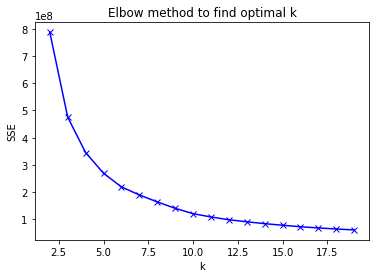

In [20]:
size_vars = ['price_per_sqft', 'lotsize_per_sqft']
e.elbow_plot(X_train_scaled, cluster_vars = size_vars)

In [21]:
train_clusters, kmeans = e.run_kmeans(X_train, X_train_scaled, k=4, 
                                    cluster_vars = ['price_per_sqft', 
                                                    'lotsize_per_sqft'], 
                                    cluster_col_name = 'size_cluster')
validate_clusters, kmeans = e.run_kmeans(X_validate, X_validate_scaled, k=4, 
                                    cluster_vars = ['price_per_sqft', 
                                                    'lotsize_per_sqft'], 
                                    cluster_col_name = 'size_cluster')
test_clusters, kmeans = e.run_kmeans(X_test, X_test_scaled, k=4, 
                                    cluster_vars = ['price_per_sqft', 
                                                    'lotsize_per_sqft'], 
                                    cluster_col_name = 'size_cluster')

In [22]:
X_train_scaled.shape

(28133, 48)

In [23]:
X_validate_scaled.shape

(12057, 48)

In [24]:
X_test_scaled.shape

(10048, 48)

In [25]:
centroid_col_names = ['centroid_' + i for i in size_vars]
centroid_col_names

centroids = pd.DataFrame(kmeans.cluster_centers_, 
             columns=centroid_col_names).reset_index().rename(columns={'index': 'size_cluster'})

In [26]:
# concatenate cluster id
X_train = pd.concat([X_train, train_clusters], axis=1)
X_validate = pd.concat([X_validate, validate_clusters], axis=1)
X_test = pd.concat([X_test, test_clusters], axis=1)

#join on clusterid to get centroids
X_train = X_train.merge(centroids, how='left', on='size_cluster').\
                set_index(X_train.index)
X_validate = X_validate.merge(centroids, how='left', on='size_cluster').\
                set_index(X_validate.index)
X_test = X_test.merge(centroids, how='left', on='size_cluster').\
                set_index(X_test.index)

In [27]:
# concatenate cluster id
X_train_scaled = pd.concat([X_train_scaled, train_clusters], 
                           axis=1)
X_validate_scaled = pd.concat([X_validate_scaled, validate_clusters], 
                           axis=1)
X_test_scaled = pd.concat([X_test_scaled, test_clusters], 
                           axis=1)

# join on clusterid to get centroids
X_train_scaled = X_train_scaled.merge(centroids, how='left', on='size_cluster').\
                set_index(X_train.index)
X_validate_scaled = X_validate_scaled.merge(centroids, how='left', on='size_cluster').\
                set_index(X_validate.index)
X_test_scaled = X_test_scaled.merge(centroids, how='left', on='size_cluster').\
                set_index(X_test.index)

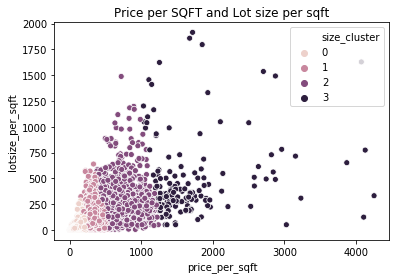

In [28]:
sns.scatterplot(x='price_per_sqft', y='lotsize_per_sqft', hue='size_cluster', data=X_train)
plt.title("Price per SQFT and Lot size per sqft")
plt.show()

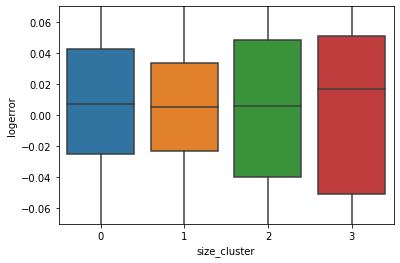

In [29]:
sns.boxplot(X_train.size_cluster, y_train.logerror)
plt.ylim(-.07,.07)
plt.show()

In [30]:
dummy_df = pd.get_dummies(X_train_scaled,
                           columns=['size_cluster'], 
                           drop_first=True)
dummy_df1 = pd.get_dummies(X_validate_scaled,
                           columns=['size_cluster'], 
                           drop_first=True)
dummy_df2 = pd.get_dummies(X_test_scaled,
                           columns=['size_cluster'], 
                           drop_first=True)

In [31]:
X_train.groupby(['size_cluster'])['bed_bath_ratio', 
                                 'age', 
                                  'buildingqualitytypeid'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

bed_bath_ratio                                        age         \
                       mean median       std       min  max       mean median   
size_cluster                                                                    
0                  1.668903   1.50  0.568849  0.400000  5.0  54.534331   57.0   
1                  1.591703   1.50  0.551601  0.500000  5.0  52.350216   55.0   
2                  1.472872   1.50  0.579697  0.333333  5.0  63.194283   66.0   
3                  1.408973   1.25  0.619385  0.500000  4.0  67.496599   69.0   

                                    buildingqualitytypeid                   \
                    std  min    max                  mean median       std   
size_cluster                                                                 
0             21.684542  1.0  139.0              6.100896    6.0  1.317507   
1             22.816293  2.0  132.0              6.027975    6.0  1.203428   
2             24.517459  2.0  128.0              6.507147    6.0  1.693418   
3             22.006342  5.0  102.0              6.598639    6.0  1.694713   

                         
              min   max  
size_cluster             
0             1.0  12.0  
1             3.0  12.0  
2             3.0  12.0  
3             4.0  12.0

In [32]:
X_train_scaled.columns

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'sqft', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'home_value', 'taxamount',
       'transactiondate', 'heatingorsystemdesc', 'county', 'age', 'taxrate',
       'acres', 'price_per_sqft', 'lotsize_per_sqft', 'bed_bath_ratio',
       'binned_price_per_sqft', 'binned_bed_bath_ratio', 'bathroomcnt_scaled',
       'bedroomcnt_scaled', 'buildingqualitytypeid_scaled', 'sqft_scaled',
       'fips_scaled', 'fullbathcnt_scaled', 'latitude_scaled',
       'longitude_scaled', 'lotsizesquarefeet_scaled', 'roomcnt_scaled',
       'unitcnt_scaled', 'yearbuilt_scaled',
       'structuretaxvaluedollarcnt_scaled', 'home_value_scaled',
       'taxamount_scaled', 'age_scaled', 'taxrate_scaled', 'acres_scaled',
       'price_per_sqft_scaled', 'lotsize_per_sqft_scaled',
       'bed_bath_ratio_scaled', 'size

In [33]:
X_train_scaled = X_train_scaled.drop(columns = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'sqft', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'home_value', 'taxamount',
       'transactiondate', 'heatingorsystemdesc', 'county', 'age', 'taxrate',
       'acres', 'price_per_sqft', 'lotsize_per_sqft', 'bed_bath_ratio',
       'binned_price_per_sqft', 'binned_bed_bath_ratio','centroid_price_per_sqft',
       'centroid_lotsize_per_sqft'])

In [34]:
X_validate_scaled = X_validate_scaled.drop(columns = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'sqft', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'home_value', 'taxamount',
       'transactiondate', 'heatingorsystemdesc', 'county', 'age', 'taxrate',
       'acres', 'price_per_sqft', 'lotsize_per_sqft', 'bed_bath_ratio',
       'binned_price_per_sqft', 'binned_bed_bath_ratio','centroid_price_per_sqft',
       'centroid_lotsize_per_sqft'])

In [35]:
X_test_scaled = X_test_scaled.drop(columns = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'sqft', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'home_value', 'taxamount',
       'transactiondate', 'heatingorsystemdesc', 'county', 'age', 'taxrate',
       'acres', 'price_per_sqft', 'lotsize_per_sqft', 'bed_bath_ratio',
       'binned_price_per_sqft', 'binned_bed_bath_ratio','centroid_price_per_sqft',
       'centroid_lotsize_per_sqft'])

## Creating a baseline

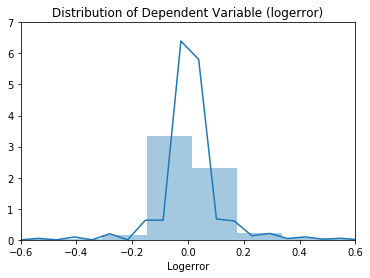

In [36]:
sns.distplot(y_train, axlabel = 'Logerror')
plt.xlim(-.6,.6)
plt.ylim(0, 7)
plt.title("Distribution of Dependent Variable (logerror)")
plt.show()

In [37]:
mean = np.mean(y_train)
print(mean)

logerror    0.017637
dtype: float64


In [38]:
y_train.shape

(28133, 1)

In [39]:
baseline_rmse = mean_squared_error(y_train, np.full(28133, np.mean(y_train)))**(1/2)
print (f'Baseline RMSE is {baseline_rmse}')

Baseline RMSE is 0.17374246260320253


# Linear Regression Model

In [40]:
# Initiate model
lm = LinearRegression()
# Fit the model
lm.fit(X_train_scaled, y_train)
# Make predictions
lm_pred = lm.predict(X_train_scaled)
# Compute RMSE
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
print(f' Linear Regression Train model RMSE is {lm_rmse}')

 Linear Regression Train model RMSE is 0.17330510791818535


# Lassolars Model

In [41]:
# Initiate model
lars = LassoLars(alpha=1)
# Fit the model
lars.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred = lars.predict(X_train_scaled)
# Compute RMSE
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
print(f' Lassolars Train model RMSE is {lars_rmse}')

 Lassolars Train model RMSE is 0.17374246260320253


In [42]:
# Initiate model alpha set to 20
lars2 = LassoLars(alpha=20)
# Fit the model
lars2.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred2 = lars2.predict(X_train_scaled)
# Compute RMSE
lars_rmse2 = mean_squared_error(y_train, lars_pred2)**(1/2)
print(f' Lassolars Train model RMSE is {lars_rmse2}')

 Lassolars Train model RMSE is 0.17374246260320253


# Polynomial Features Model

In [43]:
# Initiate model
pf = PolynomialFeatures(degree=2)

# Fit and transform the model to get new features (originals squared)
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)  
X_test_squared = pf.transform(X_test_scaled)          

# New features inputed into linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute RMSE
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
print(f' Polynomial Features model RMSE is {lm_squared_rmse}')

 Polynomial Features model RMSE is 0.17220733967604554


### Take aways:
    - Polynomial performed the best with a RMSE of 0.17220
    - Linear Regression model was the 2nd best with a RMSE of 0.17330
    - Both Lassolars models performed the same with an RMSE of 0.17374
    - Going to validate on the 3 top models including the first Lassolars

# Validate Linear Regression

In [44]:
# Make predictions
lm_pred_v = lm.predict(X_validate_scaled)
# Compute RMSE
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
print(f' Linear Regression validate model RMSE is {lm_rmse_v}')

 Linear Regression validate model RMSE is 0.16435997145710343


# Validate Lassolars

In [46]:
# Make predictions
lars_pred_v = lars.predict(X_validate_scaled)
# Compute RMSE
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**(1/2)
print(f' Lassolars validate model RMSE is {lars_rmse_v}')

 Lassolars validate model RMSE is 0.16411613234388617


# Validate Polynomial Features

In [47]:
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute RMSE
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
print(f' Polynomial validate model RMSE is {lm_squared_rmse_v}')

 Polynomial validate model RMSE is 7679292.500385546


### Takeaways:
    - 

## Building quality type id and bed bath ratio clusters (n_clusters = 4)

In [ ]:
#home_vars = ['buildingqualitytypeid', 'bed_bath_ratio']
e.elbow_plot(X_train_scaled, cluster_vars = home_vars) 

In [ ]:
train_clusters, kmeans = e.run_kmeans(X_train, X_train_scaled, k=4, 
                                    cluster_vars = ['buildingqualitytypeid', 'bed_bath_ratio'], 
                                    cluster_col_name = 'home_cluster')

In [ ]:
centroid_col_names = ['centroid_' + i for i in home_vars]
centroid_col_names

centroids = pd.DataFrame(kmeans.cluster_centers_, 
             columns=centroid_col_names).reset_index().rename(columns={'index': 'home_cluster'})

In [ ]:
centroids

In [ ]:
# concatenate cluster id
X_train = pd.concat([X_train, train_clusters], axis=1)
X_validate = pd.concat([X_validate, validate_clusters], axis=1)
X_test = pd.concat([X_test, test_clusters], axis=1)

# join on clusterid to get centroids
X_train = X_train.merge(centroids, how='left', on='home_cluster').\
                set_index(X_train.index)
X_validate = X_validate.merge(centroids, how='left', on='home_cluster').\
                set_index(X_validate.index)
X_test = X_test.merge(centroids, how='left', on='home_cluster').\
                set_index(X_test.index)

In [ ]:
# concatenate cluster id
X_train_scaled = pd.concat([X_train_scaled, train_clusters], 
                           axis=1)
X_validate_scaled = pd.concat([X_validate_scaled, validate_clusters], 
                           axis=1)
X_test_scaled = pd.concat([X_test_scaled, test_clusters], 
                           axis=1)

# join on clusterid to get centroids
X_train_scaled = X_train_scaled.merge(centroids, how='left', on='home_cluster').\
                set_index(X_train.index)
X_validate_scaled = X_validate_scaled.merge(centroids, how='left', on='home_cluster').\
                set_index(X_validate.index)
X_test_scaled = X_test_scaled.merge(centroids, how='left', on='home_cluster').\
                set_index(X_test.index)


In [ ]:
X_train_scaled.head()